Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Best Parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Accuracy: 0.6656

Classification Report:
               precision    recall  f1-score   support

           5       0.72      0.79      0.75       149
           6       0.64      0.53      0.58       128
           7       0.56      0.63      0.59        43

    accuracy                           0.67       320
   macro avg       0.64      0.65      0.64       320
weighted avg       0.66      0.67      0.66       320



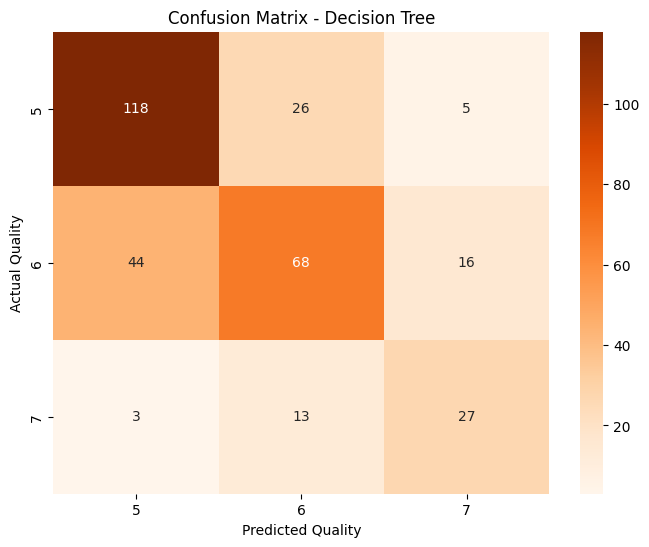

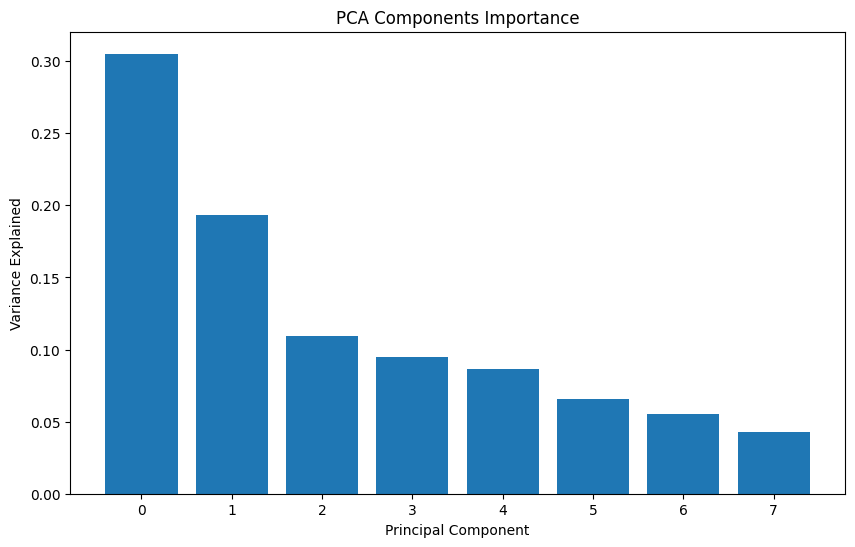

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PowerTransformer, RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# Load and clean data
data = pd.read_csv("/content/drive/MyDrive/wineQualityReds.csv")
data = data.iloc[:, 1:]  # Remove index column

# Simplify target classes
def simplify_labels(y):
    y = np.where(y <= 5, 5, y)  # 3,4,5 → 5
    y = np.where(y == 6, 6, y)
    y = np.where(y >= 7, 7, y)  # 7,8 → 7
    return y

# Feature engineering
data['total_acidity'] = data['fixed.acidity'] + data['volatile.acidity']
data['sulfur_ratio'] = data['free.sulfur.dioxide'] / (data['total.sulfur.dioxide'] + 1e-6)
data['alcohol_acidity_ratio'] = data['alcohol'] / (data['volatile.acidity'] + 0.1)

X = data.drop('quality', axis=1).values
Y = simplify_labels(data['quality'].values)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Preprocessing
preprocessor = PowerTransformer(method='yeo-johnson')
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PCA
pca = PCA(n_components=0.95)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# SMOTE
smote = SMOTE(random_state=42)
X_train, Y_train = smote.fit_resample(X_train, Y_train)

# Grid search for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=StratifiedKFold(n_splits=5),
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, Y_train)
best_tree = grid_search.best_estimator_

# Evaluation
Y_pred = best_tree.predict(X_test)
accuracy = accuracy_score(Y_test, Y_pred)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:\n", classification_report(Y_test, Y_pred))

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['5', '6', '7'],
            yticklabels=['5', '6', '7'])
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# PCA variance
plt.figure(figsize=(10,6))
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Components Importance')
plt.show()
